In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

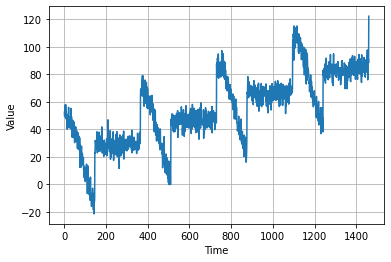

In [10]:
plot_series(time, series, format="-", start=0, end=None)

In [11]:
print(series)

[ 52.48357   49.35275   53.314735 ...  91.37325   88.32383  122.30772 ]


In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [20]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.02205037],
       [ 0.05472988],
       [-0.03037808],
       [-0.05868592],
       [ 0.04091155],
       [ 0.03470922],
       [-0.01497883],
       [ 0.01495398],
       [-0.09140222],
       [ 0.09143338],
       [ 0.0490286 ],
       [-0.09818976],
       [-0.03613786],
       [ 0.12749404],
       [-0.07060042],
       [ 0.04809422],
       [ 0.09408885],
       [ 0.18115751],
       [ 0.26603067],
       [ 0.41493475]], dtype=float32), array([0.01474747], dtype=float32)]


In [31]:
for x, y in dataset:
  print(x.numpy(),"||||>>>", y.numpy())

[[ 47.617447    55.74531     58.221962    53.5481      57.82629
   49.2742      58.26888     62.078083    48.130997    47.079636
   55.936584    55.930805    44.782898    44.661682    44.720486
   38.77553     40.274677    39.219364    39.77539     42.817646  ]
 [ 46.87793     42.307915    44.656895    51.5815      43.63659
   50.67116     40.81647     49.086952    53.619343    34.027466
   42.37602     49.22129     45.29673     48.144333    43.245922
   46.676632    45.44373     52.040035    47.452827    47.84891   ]
 [ 70.70246     63.04496     69.481316    54.984783    59.61497
   62.283337    62.12776     59.268875    64.25051     55.40607
   59.631157    60.53453     62.086494    62.645008    53.02789
   50.536366    64.142975    58.955788    53.083527    64.105736  ]
 [ 62.283337    62.12776     59.268875    64.25051     55.40607
   59.631157    60.53453     62.086494    62.645008    53.02789
   50.536366    64.142975    58.955788    53.083527    64.105736
   56.444798    61.2719

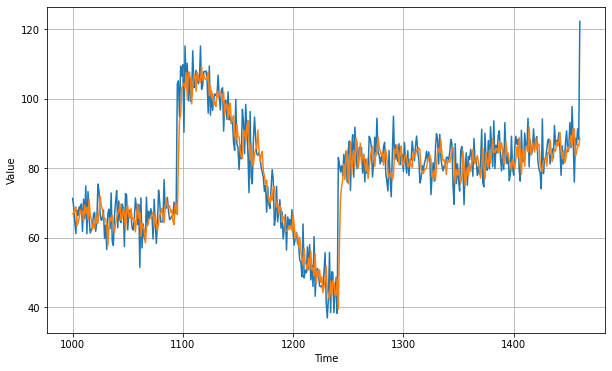

In [32]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.035863